Domingo, Kenneth V.<br />
2015-03116<br />
Video and Image Processing Group, Instrumentation Physics Laboratory

## References:

[1] Mo, Y., Zhang, A., Zheng, F., and Zhou, N. (2013). An image compression-encryption algorithm based on 2-D compressive sensing. <i>Journ. of Computational Info. Systems <b>9</b></i>(24): 10057-10064.

[2] Mohimani, H., Babaie-Zadeh, M., and Jutten, C. (2008). A fast approach for overcomplete sparse decomposition based on smoothed L0 norm. <i>IEEE Trans. on Signal Processing <b>57</b></i>(1): 289-301. arXiv:0809.2508v2.

In [1]:
import numpy as np
import numpy.random as rd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as mp
import scipy.fftpack as fft
import cv2 as cv
import sklearn.metrics as skm
import scipy.ndimage as img
import scipy.linalg as la
import time
from tqdm.notebook import tqdm, trange
from mpl_toolkits.mplot3d import Axes3D
from skimage.metrics import structural_similarity as ssim
from jupyterthemes import jtplot
from copy import deepcopy

In [13]:
rd.seed(314)
jtplot.reset()
sns.set()
sns.set_context('talk')
mp.rcParams["figure.figsize"] = (5*16/9, 5)
mp.rcParams["figure.dpi"] = 100

In [26]:
def dct2(x):
    return fft.dct(fft.dct(x.T, norm='ortho').T, norm='ortho')

def idct2(x):
    return fft.idct(fft.idct(x.T, norm='ortho').T, norm='ortho')


def normalize(data):
    data = data.astype(float)
    data -= data.min()
    data /= data.max()
    return data

"""Implementation of the Smoothed L0 Optimisation algorithm developed by Mohimani et al, see http://ee.sharif.edu/~SLzero/ for details."""

def gaussian_F(x_i, sigma):
    """Calculate the maximisation function f_{sigma} for an element of the vector x"""
    x = np.abs(x_i)
    return x_i * np.exp(-1*x*x/(2*sigma*sigma))

Fsigma_gauss = np.vectorize(gaussian_F, otypes=[np.float_]) #Vectorize the gaussian function

def SL0(A, b, **kwargs):
    """Function that performs the SL0 algorithm given the matrix A and b, and a minimum value of sigma.
    Arguments: 
     - A: numpy matrix
     - b: numpy matrix
     - sigma_min: Float, minimum value of the approximation parameter sigma. A sensible default is 1e-12
    Optional keyword arguments:
    - FSigma: vectorized function that takes an element of a vector, and the parameter sigma, as arguments. Defaults to
    the Gaussian form used by the authors
    - L: Number of steps of the gradient ascent step, defaults to 3
    - mu_0: Gradient in the gradient ascent step, defaults to 2
    - sigma_decrease: Amount by which the approximation parameter decreases each step
    """
    #Defaults for mu_0, L, decrease factor taken from the paper
    Fsigma = kwargs.pop('Fsigma', Fsigma_gauss)
    sigma_min = kwargs.pop("sigma_min", 1e-12)
    mu_0 = kwargs.pop('mu_0', 2)
    L = kwargs.pop('L', 3)
    sdf = kwargs.pop('sigma_decrease',0.5)
    A_plus = np.linalg.pinv(A)
    x = A_plus.dot(b)
    sigma = 2*np.max(np.abs(x))
    while sigma > sigma_min:
        for i in range(L): #Do L rounds of gradient ascent
            delta = Fsigma(x, sigma)
            x -= mu_0*delta
            x -= A_plus.dot(A.dot(x) - b)
        sigma *= sdf #Sigma decrease factor value chosen b the authors
    return np.around(x, decimals=10)

def F_gpu(x_i, sigma):
    """Calculate the maximisation function f_{sigma} for an element of the vector x"""
    x = tf.abs(x_i)
    return x_i * tf.exp(-1*x*x/(2*sigma*sigma))

def SL0_gpu(A, b, **kwargs):
    Fsigma = kwargs.pop('Fsigma', F_gpu)
    sigma_min = kwargs.pop("sigma_min", 1e-12)
    mu_0 = kwargs.pop('mu_0', 2)
    L = kwargs.pop('L', 3)
    sdf = kwargs.pop('sigma_decrease',0.5)
    A = tf.convert_to_tensor(A, dtype=tf.float32)
    b = tf.convert_to_tensor(b, dtype=tf.float32)
    A_plus = tf.linalg.pinv(A)
    x = tf.linalg.matmul(A_plus, b)
    sigma = 2 * np.max(np.abs(x.numpy()))
    while sigma > sigma_min:
        for i in range(L): #Do L rounds of gradient ascent
            delta = Fsigma(x, sigma)
            x -= mu_0*delta
            x -= tf.linalg.matmul(A_plus, tf.linalg.matmul(A, x) - b)
        sigma *= sdf #Sigma decrease factor value chosen b the authors
    return x.numpy()


def correlation(sig):
    #horizontal
    x, xs = [], []
    for i in range(8000):
        px = rd.randint(len(sig)-1)
        py = rd.randint(len(sig.T)-1)
        x.append(sig[py,px])
        xs.append(sig[py,px+1])
    num = np.sum((x - np.mean(x))*(xs - np.mean(xs)))
    den = np.sqrt(np.sum((x - np.mean(x))**2) * np.sum((xs - np.mean(xs))**2))
    C_h = num/den
    
    #vertical
    x, xs = [], []
    for i in range(8000):
        px = rd.randint(len(sig)-1)
        py = rd.randint(len(sig.T)-1)
        x.append(sig[py,px])
        xs.append(sig[py+1,px])
    num = np.sum((x - np.mean(x))*(xs - np.mean(xs)))
    den = np.sqrt(np.sum((x - np.mean(x))**2) * np.sum((xs - np.mean(xs))**2))
    C_v = num/den
    
    #diagonal
    x, xs = [], []
    for i in range(8000):
        px = rd.randint(len(sig)-1)
        py = rd.randint(len(sig.T)-1)
        x.append(sig[py,px])
        xs.append(sig[py+1,px+1])
    num = np.sum((x - np.mean(x))*(xs - np.mean(xs)))
    den = np.sqrt(np.sum((x - np.mean(x))**2) * np.sum((xs - np.mean(xs))**2))
    C_d = num/den
    
    return C_h, C_v, C_d

def mse(X,Y):
    return 1/X.size * np.sum((X - Y)**2)

In [16]:
def encrypt(filename, compression, key1, key2, key3):
    X = cv.imread(filename, 0)
    N = len(X)
    M = int(compression*N)
    lamda1 = [key1]
    lamda2 = [key2]

    for i in range(1, 2*N):
        lamda1.append(key3*lamda1[i-1]*(1 - lamda1[i-1]))
        lamda2.append(key3*lamda2[i-1]*(1 - lamda2[i-1]))

    s1 = np.array(lamda1[N:])
    s2 = np.array(lamda2[N:])

    n = np.arange(0,N)
    sorty1 = np.array([s1, n]).T
    sorty2 = np.array([s2, n]).T
    sorty1 = sorty1[sorty1[:,0].argsort()]
    sorty2 = sorty2[sorty2[:,0].argsort()]
    l1 = sorty1.T[1].astype("uint8")
    l2 = sorty2.T[1].astype("uint8")

    H = la.hadamard(2**(np.round(np.log2(N)).astype(int)))
    Phi1 = H[l1[:M],:N]
    Phi2 = H[l2[:M],:N]

    Psi = fft.dct(np.identity(N))
    beta1 = Phi1.dot(Psi.T.dot(X))

    beta = Psi.T.dot(X.T.dot(Psi))
    beta2 = Psi.T.dot(beta1.T)

    Y = Phi2.dot(beta.dot(Phi1.T))
    return Y, compression

def decrypt(signal_in, decompress, key1, key2, key3):
    M = len(signal_in)
    N = int(M/decompress)
    lamda1 = [key1]
    lamda2 = [key2]

    for i in range(1, 2*N):
        lamda1.append(key3*lamda1[i-1]*(1 - lamda1[i-1]))
        lamda2.append(key3*lamda2[i-1]*(1 - lamda2[i-1]))

    s1 = np.array(lamda1[N:])
    s2 = np.array(lamda2[N:])

    n = np.arange(0,N)
    sorty1 = np.array([s1, n]).T
    sorty2 = np.array([s2, n]).T
    sorty1 = sorty1[sorty1[:,0].argsort()]
    sorty2 = sorty2[sorty2[:,0].argsort()]
    l1 = sorty1.T[1].astype("uint8")
    l2 = sorty2.T[1].astype("uint8")

    H = la.hadamard(2**(np.round(np.log2(N)).astype(int)))
    Phi1 = H[l1[:M],:N]
    Phi2 = H[l2[:M],:N]

    ydir1 = SL0_gpu(Phi2, signal_in)
    ydir2 = SL0_gpu(Phi1, ydir1.T)

    Y_re = idct2(ydir2)
    return Y_re, decompress

In [17]:
lena_in = cv.imread('lena.png', 0)
k = int(lena_in.size * 0.75)
ri = rd.choice(lena_in.size, k, replace=False)
lena_mask = 255*np.ones(lena_in.shape)
lena_mask.T.flat[ri] = lena_in.T.flat[ri]

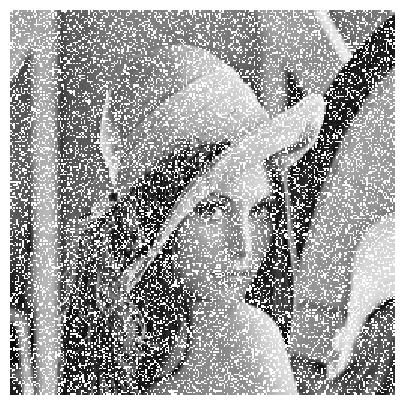

In [18]:
mp.imshow(lena_mask, "gray")
mp.axis('off')
# mp.savefig("lena_masked.png", bbox_inches="tight", dpi=300, transparent=True)
mp.show()

## Simulation

In [27]:
lena_in = cv.imread("lena.png", 0)
lena_enc, lena_comp = encrypt("lena.png", 0.75, 0.11, 0.24, 3.99)
lena_enc_scaled = (lena_enc/lena_enc.max() * 255).astype("uint8")
lena_dec, lena_decomp = decrypt(lena_enc, 0.75, 0.11, 0.24, 3.99)
lena_resc = (lena_dec/lena_dec.max() * 255).astype("uint8")

In [28]:
lena_wrong1 = decrypt(lena_enc, 0.75, 0.11+1e-16, 0.24, 3.99)[0]
lena_wrong2 = decrypt(lena_enc, 0.75, 0.11, 0.24+1e-16, 3.99)[0]
lena_wrong1_scaled = (lena_wrong1/lena_wrong1.max() * 255).astype("uint8")
lena_wrong2_scaled = (lena_wrong2/lena_wrong2.max() * 255).astype("uint8")

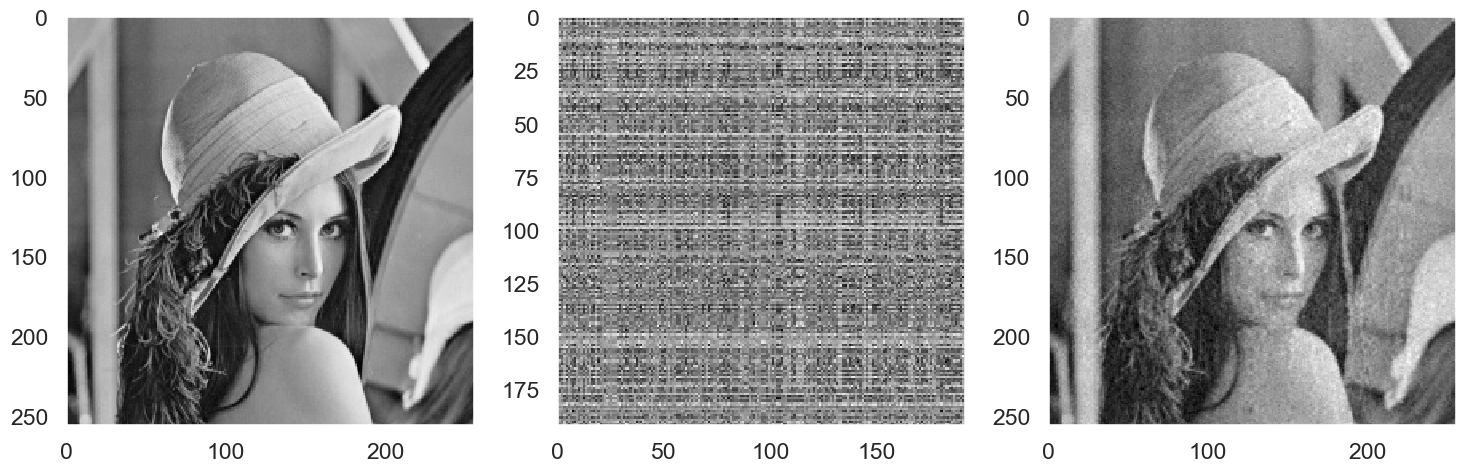

In [29]:
fig = mp.figure(figsize=(5*3, 5), dpi=100)

ax = fig.add_subplot(131)
ax.imshow(lena_in, cmap="gray")
ax.grid(0)
# ax.axis('off')

ax = fig.add_subplot(132)
ax.imshow(lena_enc, cmap="gray")
ax.grid(0)
# ax.axis('off')

ax = fig.add_subplot(133)
ax.imshow(lena_resc, cmap="gray")
ax.grid(0)
# ax.axis('off')

mp.tight_layout()
# mp.savefig("encryption.png", bbox_inches="tight", dpi=300)
mp.show()

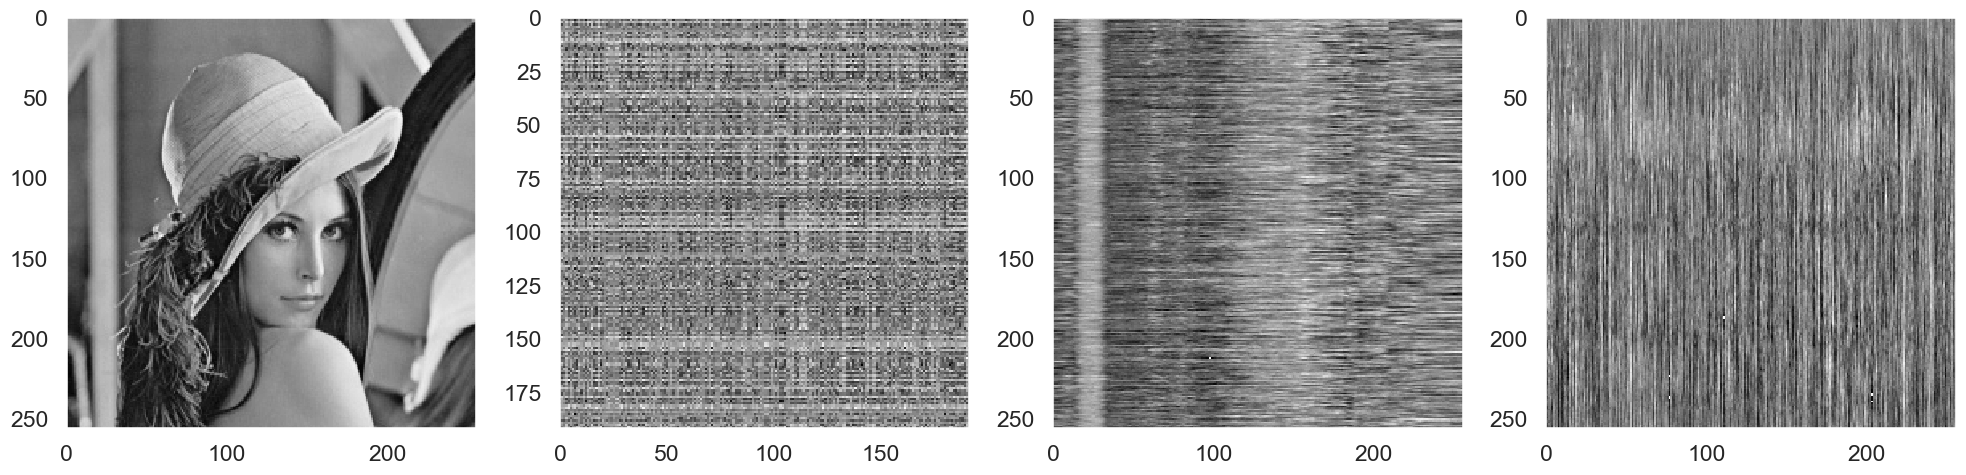

In [17]:
fig = mp.figure(figsize=(5*4, 5), dpi=100)

ax = fig.add_subplot(141)
ax.imshow(lena_in, cmap="gray")
ax.grid(0)
# ax.axis('off')

ax = fig.add_subplot(142)
ax.imshow(lena_enc, cmap="gray")
ax.grid(0)
# ax.axis('off')

ax = fig.add_subplot(143)
ax.imshow(lena_wrong1_scaled, cmap="gray")
ax.grid(0)
# ax.axis('off')

ax = fig.add_subplot(144)
ax.imshow(lena_wrong2_scaled, cmap="gray")
ax.grid(0)
# ax.axis('off')

mp.tight_layout()
# mp.savefig("wrong_decrypt.png", bbox_inches="tight", dpi=300)
mp.show()

In [18]:
print(skm.mean_squared_error(lena_resc/lena_resc.max(), lena_in/lena_in.max()))

0.024262499057616474


In [25]:
pep_in = cv.imread("peppers.jpg", 0)
pep_enc, pep_comp = encrypt("peppers.jpg", 0.75, 0.11, 0.24, 3.99)
pep_enc_scaled = (pep_enc/pep_enc.max() * 255).astype("uint8")
pep_dec, pep_decomp = decrypt(pep_enc, 0.75, 0.11, 0.24, 3.99)
pep_resc = (pep_dec/pep_dec.max() * 255).astype("uint8")

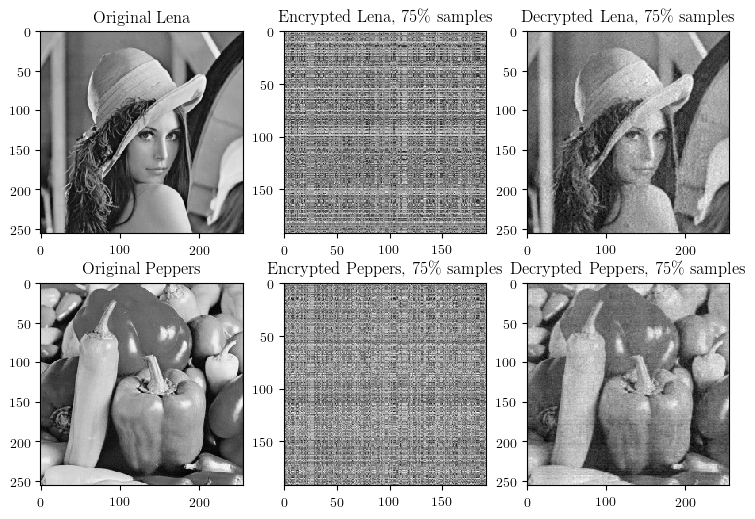

In [30]:
fig = mp.figure(figsize=(5*16/9, 5*1.2))

ax = fig.add_subplot(231)
ax.imshow(lena_in, cmap="gray")
ax.set_title("Original Lena")

ax = fig.add_subplot(232)
ax.imshow(lena_enc, cmap="gray")
ax.set_title("Encrypted Lena, {0:d}\% samples".format(int(lena_comp*100)))

ax = fig.add_subplot(233)
ax.imshow(lena_resc, cmap="gray")
ax.set_title("Decrypted Lena, {0:d}\% samples".format(int(lena_decomp*100)))

ax = fig.add_subplot(234)
ax.imshow(pep_in, cmap="gray")
ax.set_title("Original Peppers")

ax = fig.add_subplot(235)
ax.imshow(pep_enc, cmap="gray")
ax.set_title("Encrypted Peppers, {0:d}\% samples".format(int(pep_comp*100)))

ax = fig.add_subplot(236)
ax.imshow(pep_resc, cmap="gray")
ax.set_title("Decrypted Peppers, {0:d}\% samples".format(int(pep_decomp*100)))

# mp.savefig("encrypt_decrypt_sample.png", bbox_inches="tight", dpi=300, transparent=True)
mp.show()

## Key sensitivity analysis

In [9]:
lena_mse = mse(lena_in, lena_resc)
print("MSE ({0:d}% samples) = {1:2.2f}".format(int(lena_comp*100), lena_mse))

NameError: name 'lena_resc' is not defined

In [45]:
pep_mse = mse(pep_in, pep_resc)
print("MSE ({0:d}% samples) = {1:2.2f}".format(int(pep_comp*100), pep_mse))

MSE (50% samples) = 110.75


In [51]:
lena_in = cv.imread("lena.png", 0)
lena_enc, lena_comp = encrypt("lena.png", 0.75, 0.11, 0.24, 3.99)
lena_enc_scaled = (lena_enc/lena_enc.max() * 255).astype("uint8")
samples = 100
keyspace = np.concatenate((
    np.linspace(-1e-14, 0, samples//2, endpoint=False),
    np.linspace(0, 1e-14, samples//2)
))

In [52]:
mse01, mse02 = [], []
ssim01, ssim02 = [], []

for k, s in enumerate(tqdm(keyspace)):
    lena_dec1 = decrypt(lena_enc, 0.75, 0.11+s, 0.24, 3.99)[0]
    lena_dec2 = decrypt(lena_enc, 0.75, 0.11, 0.24+s, 3.99)[0]
    lena_resc1 = (normalize(lena_dec1) * 255).astype("uint8")
    lena_resc2 = (normalize(lena_dec2) * 255).astype("uint8")
#     mse01.append(skm.mean_squared_error(normalize(lena_in), normalize(lena_resc1)))
#     mse02.append(skm.mean_squared_error(normalize(lena_in), normalize(lena_resc2)))
    ssim01.append(ssim(normalize(lena_in), normalize(lena_resc1)))
    ssim02.append(ssim(normalize(lena_in), normalize(lena_resc2)))
    
#     mse = np.array([mse01, mse02])
    sims = np.array([ssim01, ssim02])
    np.save("ssimcurves.npy", sims)

In [32]:
mse01, mse02 = np.load('msecurves.npy')
ssim01, ssim02 = np.load('ssimcurves.npy')

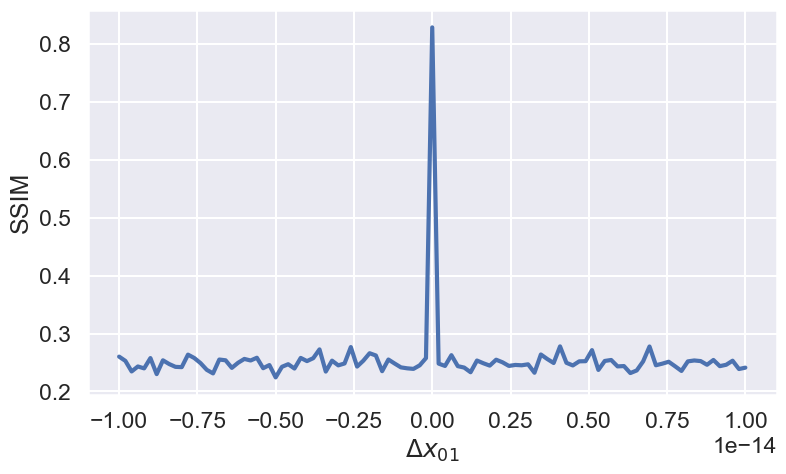

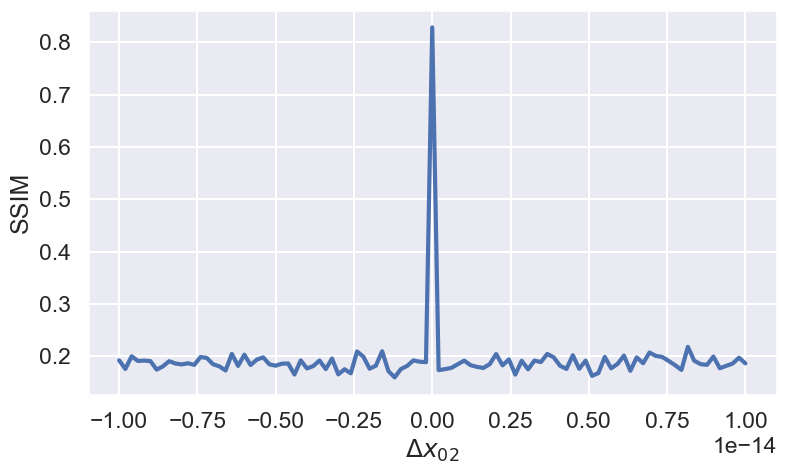

In [54]:
mp.plot(keyspace, ssim01, lw=3)
mp.xlabel("$\Delta x_{01}$")
mp.ylabel("SSIM")
mp.savefig("ssim-x01.png", bbox_inches="tight", dpi=300)
mp.show()

mp.plot(keyspace, ssim02, lw=3)
mp.xlabel("$\Delta x_{02}$")
mp.ylabel("SSIM")
mp.savefig("ssim-x02.png", bbox_inches="tight", dpi=300)
mp.show()

In [56]:
ssim01[50], ssim02[50]

(0.828567650958184, 0.828567650958184)

## Correlation of adjacent pixels

In [23]:
corrcoef_lena_orig = correlation(normalize(lena_in))
corrcoef_lena_orig

(0.9425884254176161, 0.9736919231997377, 0.9140717723187516)

In [24]:
corrcoef_lena_enc = correlation(normalize(lena_enc))
corrcoef_lena_enc

(0.4227910773672545, 0.022842923899292832, -0.054602497934207114)

In [58]:
corrcoef_pep_orig = correlation(pep_in)
corrcoef_pep_orig

(0.9596156204200834, 0.9661756413172004, 0.9290838312077632)

In [59]:
corrcoef_pep_enc = correlation(pep_enc)
corrcoef_pep_enc

(0.18815131664688803, 0.13967854547857503, 0.0019784501626790266)

## Histograms

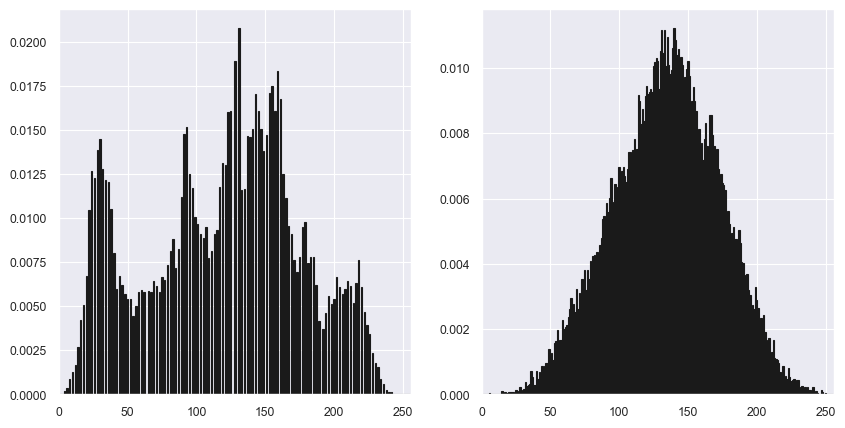

In [47]:
fig = mp.figure(figsize=(5*2, 5))

ax = fig.add_subplot(121)
hist = cv.calcHist(
    [(normalize(lena_in)*255).astype('uint8')],
    [0],
    None,
    [256],
    [0, 256]
).squeeze()/lena_in.size
ax.bar(range(256), hist, color='k', width=1.0, ec="k")
ax.set_xlim(0, 256)
# ax.set_title("Histogram of original Lena")

ax = fig.add_subplot(122)
hist = cv.calcHist(
    [(normalize(lena_enc)*255).astype('uint8')],
    [0],
    None,
    [256],
    [0, 256]
).squeeze()/lena_enc.size
ax.bar(range(256), hist, color='k', width=1.0, ec="k")
ax.set_xlim(0, 256)
# ax.set_title("Histogram of encrypted Lena")

# mp.savefig("histogram.png", bbox_inches="tight", dpi=300)
mp.show()